In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

# 1 (a)

In [2]:
# Uses complex variables to approximate df/dx 

def deriv(func, x, h):
    dfdx = np.imag(func(x + 1j*h)) / h
    return dfdx

# 1 (b)

Analytic Answer:

$f = sin^3(x)$

$\frac{df}{dx} = 3sin^2(x)cos(x)$

$\frac{df}{dx}(x = 1.5) = 3sin^2(1.5)cos(1.5)$

In [3]:
# Analytic answer
dfdx_analytic = 3 * np.sin(1.5)**2 * np.cos(1.5)
print(f"Analytic Answer: {dfdx_analytic}")

def sin3(x):
    return np.sin(x)**3

# Sanity check of analytic answer
dfdx_check = scipy.misc.derivative(sin3, x0=1.5, dx=1e-6)
print(f"Sanity Check: {dfdx_check}")

# Making sure approximation works
dfdx_approx = deriv(sin3, 1.5, 1e-6)
print(f"Approx Answer: {dfdx_approx}")


Analytic Answer: 0.21114975082386195
Sanity Check: 0.21114975096159228
Approx Answer: 0.21114975082410797


/var/folders/bm/3sg547cn5lnbz135hzdjm74c0000gn/T/ipykernel_19853/3990579282.py:9: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  dfdx_check = scipy.misc.derivative(sin3, x0=1.5, dx=1e-6)


In [4]:
def center_deriv(func, x, h):
    return (func(x + h) - func(x - h)) / (2 * h)


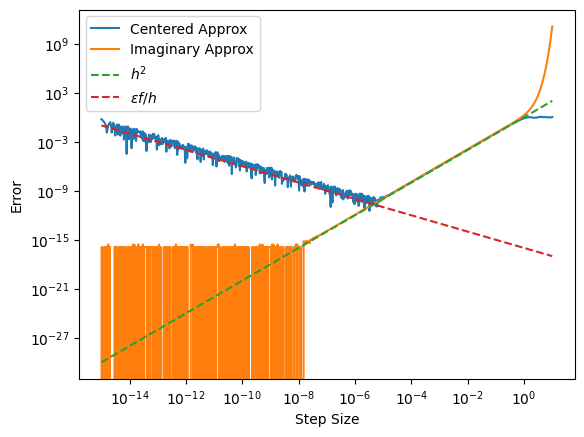

In [5]:
step_size_arr = np.logspace(-15,1,1000)
err1_arr = []
err2_arr = []

for h in step_size_arr:
    err1 = np.abs(center_deriv(sin3, 1.5, h) - dfdx_analytic)
    err2 = np.abs(deriv(sin3, 1.5, h) - dfdx_analytic)
    err1_arr.append(err1 / dfdx_analytic)
    err2_arr.append(err2 / dfdx_analytic)
    
plt.loglog(step_size_arr, err1_arr, label="Centered Approx")
plt.loglog(step_size_arr, err2_arr, label="Imaginary Approx")
plt.loglog(step_size_arr, step_size_arr**2,'--', label="$h^{2}$")
plt.loglog(step_size_arr, 10**-16*sin3(1.5)/step_size_arr,'--', label="$ {\epsilon f}/{h}$")
plt.xlabel("Step Size")
plt.ylabel("Error")
plt.legend()
plt.show()

When we use a Taylor expansino to create these approximations, we throw out higher order terms. The more terms left in, the smaller the error. For CD, we learned in class that 2nd order approximations have an optimal step size of ~$10^{-5.3}$ for double precision floats, hence why the lowest error is at that step size. At smaller step sizes, the roundoff error terms dominates, and at larger step sizes the neglected Taylor series term dominates. Both approximations fail at a step size greater than 1 due to the inherent assumptions we make about step size being << 1 for a Taylor expansion.

For the IS approximation, we do not actually see a roundoff error at smaller step sizes, because the formula is not actually a finite difference formula. It is therefore more accurate for smaller step sizes compared to CD. But once they both enter higher step sizes, where roundoff no longer dominates, they both follow a 2nd order approximation. Because we do not divide by our step size $\Delta x$ in the IS approximation, it is actually 2nd order. Normally we do divide out a $\Delta x$ for finite difference, like forward Euler. An interesting approach to approximation.



# 2

I am a bit stuck on this one but my intuition is saying that this would perhaps be a good application of a leapfrog method because it is best suited for second derivatives of this form. Energy and momentum need to be conserved here, so it would make sense to use a symplectic integrator.

Tried a method using this video, didn't work out very well:
https://www.youtube.com/watch?v=RUjn_saoD0I&t=696s

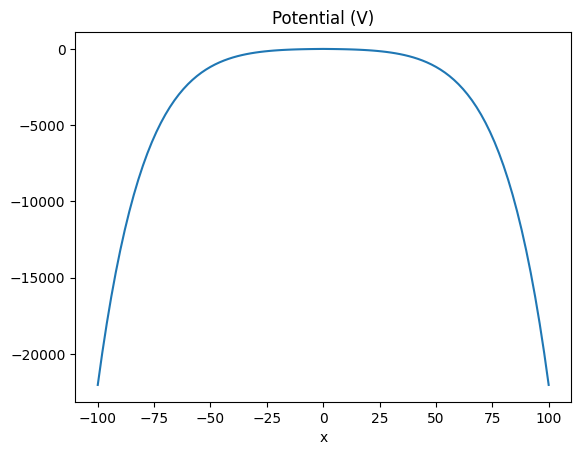

Ground state energy: -19916.306911883174


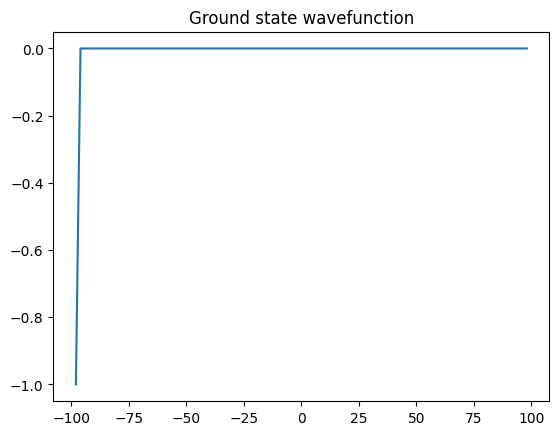

In [6]:
a = 100
m = 1
hbar = 1
N = 100
x = np.linspace(-100, a, N+1)
dx = x[1] - x[0]
V0 = 10
V = -np.exp(np.sqrt(np.abs(x)))
plt.plot(x, V)
plt.title('Potential (V)')
plt.xlabel('x')
plt.show()

H = (dx**2) * np.diag(np.ones(N-1)) + V[1:-1]*np.diag(np.ones(N-1))
H = H + -1/(dx**2) * np.diag(np.ones(N-2),1)
H = H + -1/(dx**2) * np.diag(np.ones(N-2),-1)

E, psi = np.linalg.eigh(H)
print(f'Ground state energy: {E[0]}')
plt.plot(x[1:-1], psi.T[0])
plt.title('Ground state wavefunction')

plt.show()

# 3

In [7]:
with open('final_data.txt', 'r') as data:
    lines = data.readlines()

x_pos = [float(line.split()[0]) for line in lines]
k_vals = np.array([float(line.split()[1]) for line in lines])


After we read in the thermal diffusivity data, we create a function that interpolates it, that way we can get a value for any given x position:

In [8]:
from scipy.interpolate import interp1d

interp = scipy.interpolate.interp1d(x_pos, k_vals)


Now we need to add in our k into the existing A matrix, but specifically so that it queries the correct x positions. I used the in class solutions from when we did insulating boundaries as a starting point.

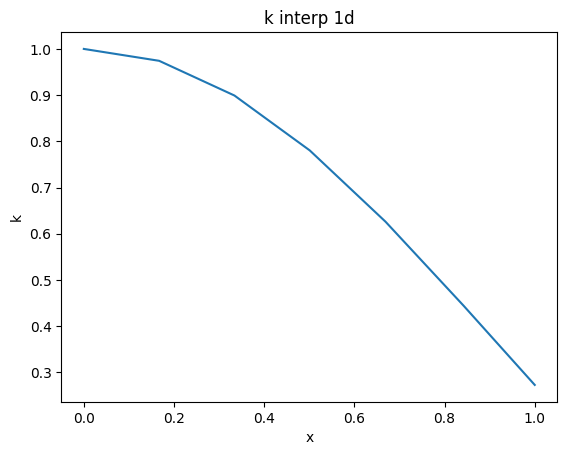

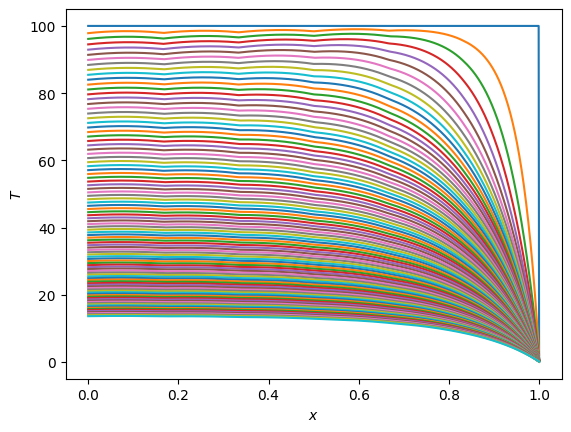

Temp at base of slab at t = 1 sec: 13.612464321290677 K


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

n = 1001
x = np.linspace(0, 1, n)
k = interp(x)
plt.plot(x, k)
plt.title('k interp 1d')
plt.xlabel('x')
plt.ylabel('k')
plt.show()

# Initial profile has T=100 everywhere except T=0 at the outer boundary
T = 100 * np.ones(n)
T[-1] = 0.0

plt.plot(x, T)
plt.xlabel(r'$x$')
plt.ylabel(r'$T$')

dx = x[1]-x[0]
time = 1
dt = 1e-2
nsteps = int(time / dt)

for i in range(1,nsteps):
    alpha = dt/dx**2

    # Calculate the matrix A in banded form
    b = (1 + 2*alpha*k) * np.ones(n)
    b[0] = 1 + alpha*k[0]       #<=========  New line to implement insulating boundary
    a = -alpha * k * np.ones(n)
    c = -alpha * k * np.ones(n)
    c[-1] = 0.0
    a[0] = 0.0
    AA = np.row_stack((a,b,c))

    # and the b vector (boundaries)
    bvec = np.zeros(n)
    #bvec[-1] = 0#  

    T = scipy.linalg.solve_banded((1,1), AA, T + alpha*bvec)
    plt.plot(x, T)
plt.show()

print(f"Temp at base of slab at t = 1 sec: {T[0]} K")



You can see the changes in the gradient where the thermal diffusivity changes values. Higher k values mean more rapid heat transfer. k is largest at near the base of slab, but the base is insulated, so the change is not very noticeable. 

# 4 

Since the time scale is so large, I think I should use an implicit scheme, since it will be stable with large step size and I will be able to see the large scale behaviour of the decay.

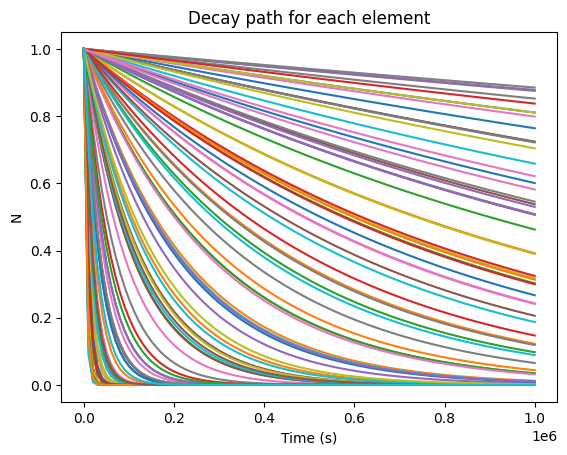

/var/folders/bm/3sg547cn5lnbz135hzdjm74c0000gn/T/ipykernel_19853/3384852136.py:33: RuntimeWarning: divide by zero encountered in divide
  plt.plot(time, np.log(1/time), label='Power law')


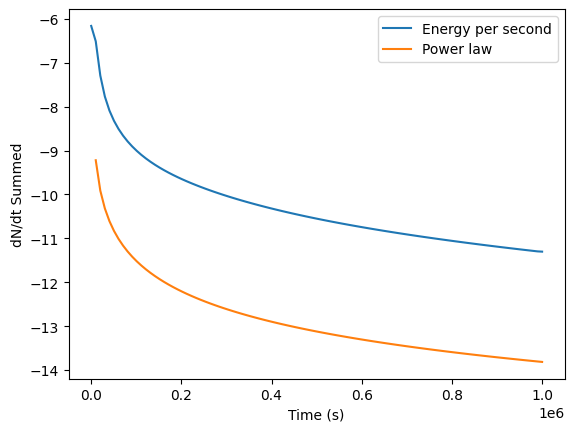

In [10]:
from scipy.stats import loguniform

N = 100
taus = loguniform.rvs(1e3, 1e7, size=N)

n_atoms = 1
t = 1e6
nsteps = 100
time = np.linspace(0, t, nsteps)
dt = t / nsteps

x = np.zeros((N,nsteps))
x[:,0] = n_atoms

dNdt = np.ones_like(x)

# For each element, calculate how N changes over time
for j, tau in enumerate(taus):
    for i in range(1, len(time)):
        x[j, i] =  x[j, i - 1] / (1 + dt / tau)
    # Calculate the gradient to find energy per second
    dNdt[j,:] = -1*np.gradient(x[j,:], time)
    plt.plot(time,x[j,:])
plt.xlabel('Time (s)')
plt.ylabel('N')
plt.title('Decay path for each element')
plt.show()

# Sum over each element
sum_all_rows = np.sum(dNdt, axis=0)

plt.plot(time,np.log(sum_all_rows), label='Energy per second')
plt.plot(time, np.log(1/time), label='Power law')
plt.xlabel('Time (s)')
plt.ylabel('dN/dt Summed')
plt.legend()
plt.show()

I am hesistant to assume I did this correct, but if so, it does seem like th total energy per second is proportional to the power law that decays as 1/t. Makes sense physically in that elements with shorter half lifes will contribute less and less to total energy release and only a few elements will contribute heavily.